In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

In [3]:
def load_data(path):
    texts = []
    emotions = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(';')
            if len(parts) == 2:
                text, emotion = parts
                texts.append(text)
                emotions.append(emotion)
    return texts, emotions

train_texts, train_labels = load_data("train.txt")
val_texts, val_labels = load_data("val.txt")
test_texts, test_labels = load_data("test.txt")

print("Sample training data:")
print(train_texts[0], "->", train_labels[0])

Sample training data:
i didnt feel humiliated -> sadness


In [4]:
def clean_text(text):
    text = nfx.remove_punctuations(text)
    text = nfx.remove_stopwords(text)
    return text.lower()

train_texts_clean = [clean_text(text) for text in train_texts]
val_texts_clean = [clean_text(text) for text in val_texts]
test_texts_clean = [clean_text(text) for text in test_texts]


In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train = vectorizer.fit_transform(train_texts_clean)
X_val = vectorizer.transform(val_texts_clean)
X_test = vectorizer.transform(test_texts_clean)


In [6]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, train_labels)

LogisticRegression(max_iter=200)

In [7]:
val_predictions = model.predict(X_val)

print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"\nValidation Accuracy: {val_accuracy:.2f}")


Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.87      0.90       275
        fear       0.89      0.79      0.83       212
         joy       0.88      0.96      0.92       704
        love       0.89      0.75      0.82       178
     sadness       0.91      0.95      0.93       550
    surprise       0.89      0.70      0.79        81

    accuracy                           0.90      2000
   macro avg       0.90      0.84      0.86      2000
weighted avg       0.90      0.90      0.90      2000


Validation Accuracy: 0.90


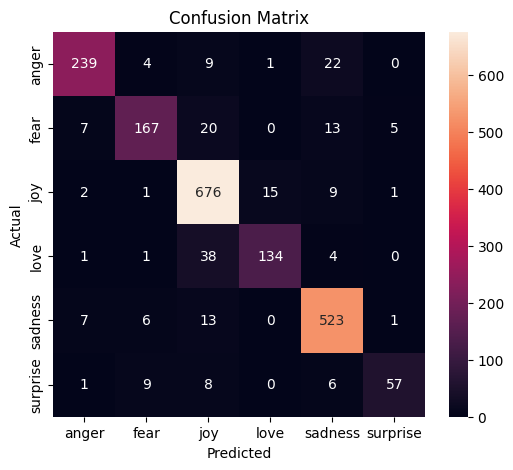

In [8]:
cm = confusion_matrix(val_labels, val_predictions)
labels = sorted(set(train_labels))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
joblib.dump((vectorizer, model), "emotion_model.joblib")
print("Model saved as 'emotion_model.joblib'")


Model saved as 'emotion_model.joblib'


In [10]:
def predict_emotion(text):
    vectorizer, model = joblib.load("emotion_model.joblib")
    cleaned = clean_text(text)
    features = vectorizer.transform([cleaned])
    prediction = model.predict(features)
    return prediction[0]

In [11]:
def save_correction(text, correct_emotion):
    with open("corrections.txt", "a", encoding='utf-8') as f:
        f.write(f"{text};{correct_emotion}\n")


In [12]:
def retrain_with_corrections():
    if os.path.exists("corrections.txt"):
        corrected_texts, corrected_labels = load_data("corrections.txt")
        all_texts = train_texts + corrected_texts
        all_labels = train_labels + corrected_labels
        all_texts_clean = [clean_text(text) for text in all_texts]
        X_all = vectorizer.fit_transform(all_texts_clean)
        model.fit(X_all, all_labels)
        joblib.dump((vectorizer, model), "emotion_model.joblib")
        print("Model updated with corrections!")

In [ ]:
print("\n--- Emotion Prediction Demo ---")
while True:
    user_input = input("Enter a sentence (or type 'exit' to stop): ")
    if user_input.lower() == 'exit':
        break
    emotion = predict_emotion(user_input)
    print("Predicted Emotion:", emotion)
    feedback = input("Is this correct? (yes/no): ").lower()
    if feedback == 'no':
        correct_emotion = input("What is the correct emotion?: ")
        save_correction(user_input, correct_emotion)
        retrain_with_corrections()
        print("Thanks! I've learned from this correction.")


--- Emotion Prediction Demo ---


Enter a sentence (or type 'exit' to stop):  i was mesmerized by her beauty


Predicted Emotion: joy
